In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
from PIL import Image
import numpy as np

#import Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
from keras.utils import to_categorical

# Define the paths to the dataset directories
train_dir = path + '/train'
test_dir = path + '/test'

# Define the image size and number of classes
img_size = (48, 48)
num_classes = 7


# Create a mapping from class names to numerical labels
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_to_label = {class_name: i for i, class_name in enumerate(class_names)}
print(class_to_label)

# Function to load images and labels from a directory
def load_images_and_labels(directory, img_size, num_classes):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Get the numerical label for the current class
        label = class_to_label.get(class_name)
        if label is None:
            print(f"Skipping unknown class: {class_name}")
            continue

        print(f"Loading images from class: {class_name} (Label: {label})")

        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            try:
                # Load image in grayscale mode
                image = Image.open(image_path).convert('L')  # 'L' mode for grayscale
                image = image.resize(img_size)
                image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)

    # Convert labels to categorical format
    labels = to_categorical(labels, num_classes=num_classes)
    labels = labels.reshape((-1, num_classes))

    return images, labels

# Load all data from train, test, and val directories
train_images, train_labels = load_images_and_labels(train_dir, img_size, num_classes)
test_images, test_labels = load_images_and_labels(test_dir, img_size, num_classes)

# Combine all data into a single dataset
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Shuffle the combined dataset
indices = np.arange(all_images.shape[0])
np.random.shuffle(indices)

all_images = all_images[indices]
all_labels = all_labels[indices]

# Split the shuffled dataset into train, test, and val sets
train_size = int(0.8 * all_images.shape[0])  # 80% for training
test_size = all_images.shape[0] - train_size  # Remaining 20% for testing

train_images = all_images[:train_size]
train_labels = all_labels[:train_size]

test_images = all_images[train_size:]
test_labels = all_labels[train_size:]

# Add a channel dimension to grayscale images
train_images = np.expand_dims(train_images, axis=-1)  # Shape: (num_samples, 48, 48, 1)
test_images = np.expand_dims(test_images, axis=-1)    # Shape: (num_samples, 48, 48, 1)

# Print the shapes of the loaded data
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Loading images from class: surprise (Label: 6)
Loading images from class: fear (Label: 2)
Loading images from class: angry (Label: 0)
Loading images from class: neutral (Label: 4)
Loading images from class: sad (Label: 5)
Loading images from class: disgust (Label: 1)
Loading images from class: happy (Label: 3)
Loading images from class: surprise (Label: 6)
Loading images from class: fear (Label: 2)
Loading images from class: angry (Label: 0)
Loading images from class: neutral (Label: 4)
Loading images from class: sad (Label: 5)
Loading images from class: disgust (Label: 1)
Loading images from class: happy (Label: 3)
Train images shape: (28709, 48, 48, 1)
Train labels shape: (28709, 7)
Test images shape: (7178, 48, 48, 1)
Test labels shape: (7178, 7)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.regularizers import l2

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1), kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val-loss', mode="min", patience=10, restore_best_weights=True)

hist = model.fit(train_images, train_labels, batch_size=256, epochs=50, shuffle=True, validation_data=(test_images, test_labels), callbacks=[early_stop, reduce_lr])


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.2420 - loss: 3.3195 - val_accuracy: 0.2502 - val_loss: 2.9231 - learning_rate: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val-loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2434 - loss: 2.8095 - val_accuracy: 0.2508 - val_loss: 2.5619 - learning_rate: 1.0000e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.2570 - loss: 2.4893 - val_accuracy: 0.3239 - val_loss: 2.2827 - learning_rate: 1.0000e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3329 - loss: 2.2277 - val_accuracy: 0.3750 - val_loss: 2.1082 - learning_rate: 1.0000e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3726 - loss: 2.0675 - val_accuracy: 0.3859 - val_loss: 1.9989 - learning_rate: 1.0000e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3881 - loss: 1.9711 - val_accuracy: 0.4093 - val_loss: 1.9154 - learning_rate: 1.0000e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4073 - loss: 1.8912 - val_accuracy: 0.4191 - val_loss: 1.8492 - learning_rate: 1.0000e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
saved_model_path = '/content/drive/MyDrive'

Mounted at /content/drive


In [ ]:
model.save(saved_model_path + '/FER_simple_CNN.keras', overwrite=True)
model.save(saved_model_path + '/FER_simple_CNN.h5',overwrite=True)

In [ ]:
# Load pretrained model (if necessary)
from tensorflow.keras.models import load_model
model = load_model(saved_model_path + '/FER_simple_CNN.h5')

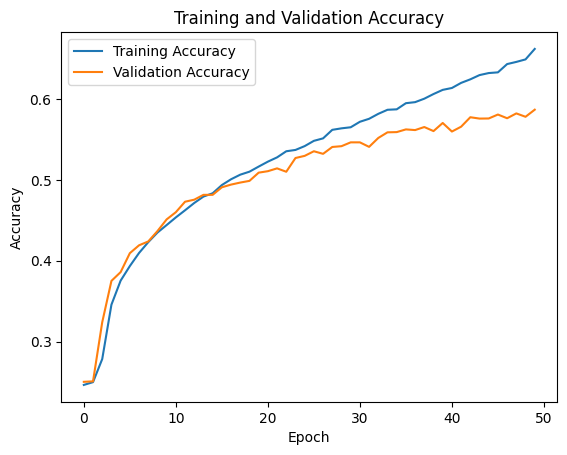

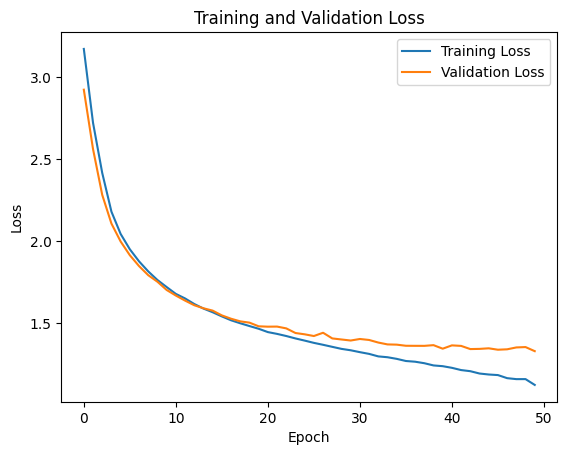

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5751 - loss: 1.3496
Validation Loss: 1.331250786781311
Validation Accuracy: 0.5867930054664612


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


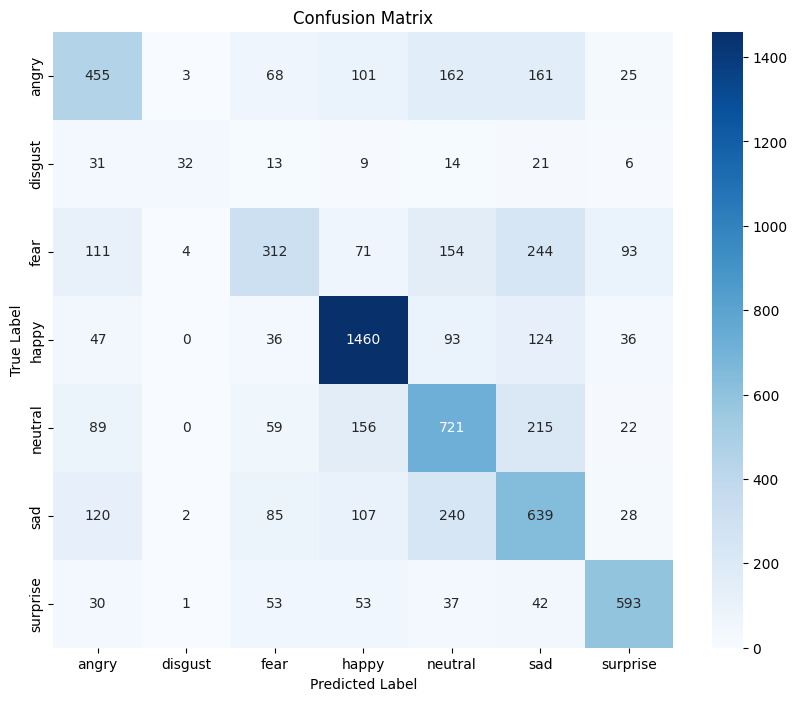


Classification Report:
              precision    recall  f1-score   support

       angry     0.5153    0.4667    0.4898       975
     disgust     0.7619    0.2540    0.3810       126
        fear     0.4984    0.3155    0.3864       989
       happy     0.7460    0.8129    0.7780      1796
     neutral     0.5074    0.5713    0.5375      1262
         sad     0.4419    0.5233    0.4792      1221
    surprise     0.7385    0.7330    0.7357       809

    accuracy                         0.5868      7178
   macro avg     0.6013    0.5252    0.5411      7178
weighted avg     0.5863    0.5868    0.5800      7178


Weighted Precision: 0.5863
Weighted Recall: 0.5868
Weighted F1-Score: 0.5800


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# Additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"\nWeighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")